# SUPPORT VECTOR REGRESSOR.

SVR is a type of support vector machine that is designed to carry out regression tasks. Its a suppervised machine learning algorithm that uses a hyperplane to determine class/value of an unknown value. Its comparable to a line of best fit in linear regression, it a line that gives the largest separation between classes. Given a set of datapoints (dimensional vector) belonging to two classes(red and blue below), a linear classifier is generated to separate them into different classes. Multiple hyperplanes are drawn but one that represents the largest margin is selected. In diagram below, H2 best separates the two groups as compared to H1. The distance between this line, illustrated by short blue connecting data points to H2, and the closest data point, circled in diagram, on either classes is maximised, these points are claled support vectors and guide drawing of a boundary differentiating classes. The best hyperplane is one with the largest distance to the nearest training data point of any class, resulting to a lower generalisation error and inturn low risk pof overfitting.     
<center><img src="../Regression Algorithms/images/Support_vector_machine.png " width=600px height=400px /></center>

A support vector machine needs a kernel which is a fuction used to determine similarities between input data, when there is a linear relationship a linear kernel is used while for non-liniear relatioships prefer non-linear. The later is more complex, basically the characteristics of data and nature of complexity guides this process. 

In this example, we will implementation Support Vector Regression (SVM) in predicting voter turnout for 2020 elections in the US counties based on a set of predictor varaiables such as historical turn out data, county population, household income , poverty levels just but a few. We will train the model to understan the relationship between these variables and voter turnout then have the model predict an unseen data. 

<center><img src="../Regression Algorithms/images/predictor_variables_SVR - Copy.png" width=800px height=400px /></center>


# 1. Data Preparation.

We have a data of US counties with election results for the year 2020. Lets import and perform some pre-processing techniques before passing it to the model. 



In [1]:
# Import Required libraries. 
import pandas as pd 
import geopandas as gpd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score  # Evaluating the model
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

In [2]:
# Load data 
path = 'F:/Programs/Secrets of ML/Data/US_Elections.gpkg'

# Read data containing county polygons. 
data = gpd.read_file(path, layer='US_CountyElections_clean')

data.columns

Index(['county_FIPS', 'name', 'population', 'state_abbr', 'state_fips',
       'state_name', 'voter_turnout_2008', 'voter_turnout_2012',
       'voter_turnout_2016', 'voter_turnout_2020', '2022_median_age',
       '2022_per_capitalincome', 'perc_2022_age_25+_no_diploma/highschool',
       'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income',
       'lifemode_5', 'region', 'geometry'],
      dtype='object')

Columns : Index(['county_FIPS', 'name', 'population', 'state_abbr', 'state_fips',
       'state_name', 'voter_turnout_2008', 'voter_turnout_2012',
       'voter_turnout_2016', 'voter_turnout_2020', '2022_median_age',
       '2022_per_capitalincome', 'perc_2022_age_25+_no_diploma/highschool',
       'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income',
       'lifemode_5', 'region', 'geometry'],
      dtype='object')


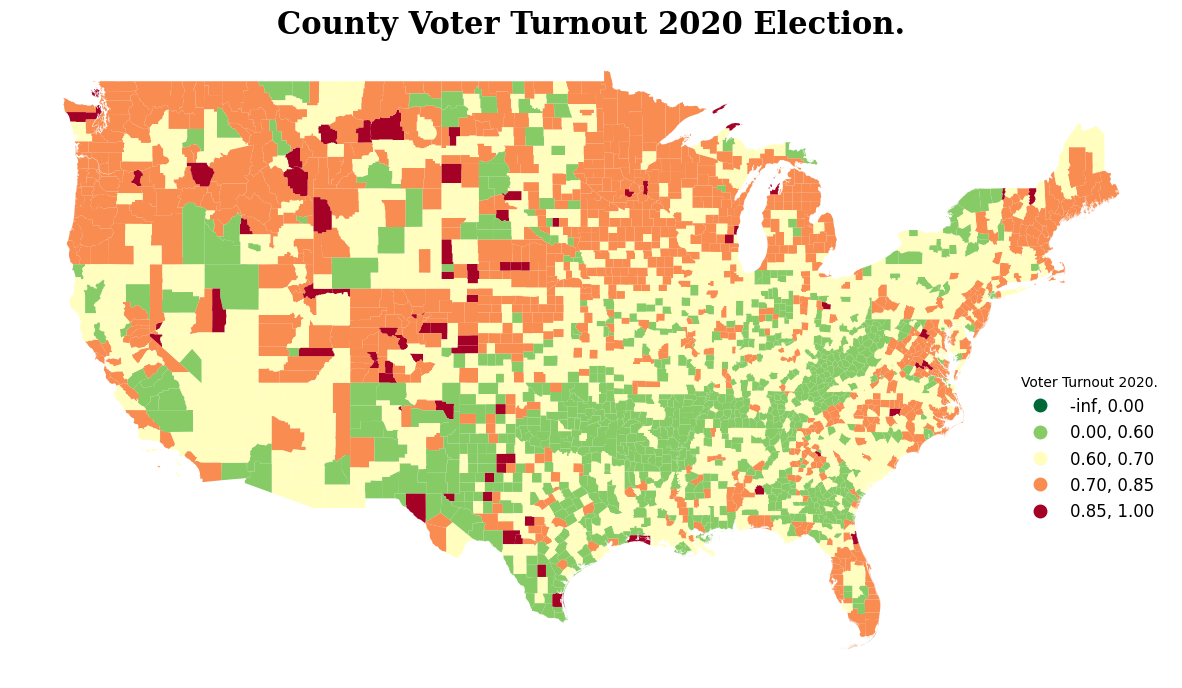

In [3]:
# Legend Parameters 
legend_kwds= {
  'loc': 'best',
  'bbox_to_anchor': (0.5, 0., 0.5, 0.5),
  #'fmt': '{:<5.0f}',
  'frameon': False,
  'fontsize': 12,
  'title': 'Voter Turnout 2020.'
}

# Legend bins 
classification_kwds={
  'bins':[0, 0.6, 0.7, 0.85, 1]
}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,15)
data.plot(ax=ax, column='voter_turnout_2020', cmap='RdYlGn_r', scheme='User_Defined',
         classification_kwds=classification_kwds, legend=True, legend_kwds=legend_kwds)

# Remove axis 
ax.set_axis_off()

# Add a title
ax.set_title('County Voter Turnout 2020 Election.', fontsize=22, fontweight='bold', 
          fontfamily='serif', color='black')

plt.show()

In [38]:
# Data properties 

# Check missing and null values in the dataframe . data type objects,  
print(f'Columns features :\n  {data.info()} \n\n ----------------------------\n')

# Distribution on numerical data 
print(f'Numerical variables distributions : \n {data.describe()} \n\n ----------------------------\n')

# Data sample 
print(f'Data head :\n {data.head(2)}')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   county_FIPS                              3108 non-null   object  
 1   name                                     3108 non-null   object  
 2   population                               3108 non-null   int64   
 3   state_abbr                               3108 non-null   object  
 4   state_fips                               3108 non-null   object  
 5   state_name                               3108 non-null   object  
 6   voter_turnout_2008                       3108 non-null   float64 
 7   voter_turnout_2012                       3108 non-null   float64 
 8   voter_turnout_2016                       3108 non-null   float64 
 9   voter_turnout_2020                       3108 non-null   float64 
 10  2022_median_age             

# 2. Feature Scalling. 

Our predictor attributes have varied distribution that may impact negatively on the model. This may increase model inaccuracies resulting to a faulty prediction. Data needs to be normalised so that they can have an equally distributed effect on the model. 

Index(['population', 'voter_turnout_2008', 'voter_turnout_2012',
       'voter_turnout_2016', '2022_median_age', '2022_per_capitalincome',
       'perc_2022_age_25+_no_diploma/highschool',
       'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income',
       'lifemode_5'],
      dtype='object')


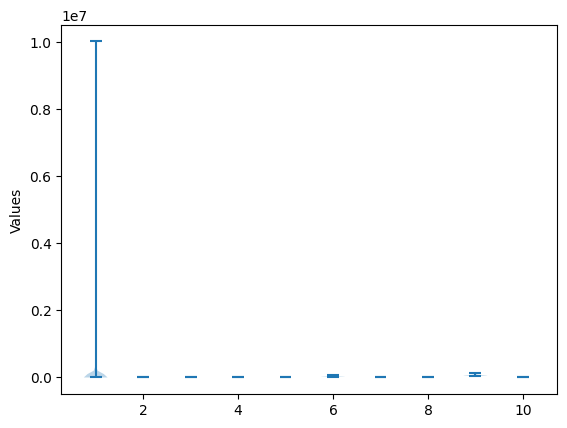

In [47]:
# Plot distribution.

# Predictor variables 
# Select numeric values that will be used as predictors 
X = data.select_dtypes(include=['int64', 'float']).drop('voter_turnout_2020', axis=1)
print(X.columns)

plt.violinplot(X)
plt.ylabel('Values')

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right')

plt.show()


Scaled data features  : 
        population  voter_turnout_2008  voter_turnout_2012  voter_turnout_2016  \
count   3108.0000           3108.0000           3108.0000           3108.0000   
mean       0.0106              0.5103              0.4900              0.5085   
std        0.0337              0.1136              0.1160              0.1101   
min        0.0000              0.0000              0.0000              0.0000   
25%        0.0011              0.4334              0.4095              0.4344   
50%        0.0026              0.5144              0.4889              0.5103   
75%        0.0068              0.5865              0.5685              0.5818   
max        1.0000              1.0000              1.0000              1.0000   

       2022_median_age  2022_per_capitalincome  \
count        3108.0000               3108.0000   
mean            0.4800                  0.2767   
std             0.1267                  0.1096   
min             0.0000                  0.00

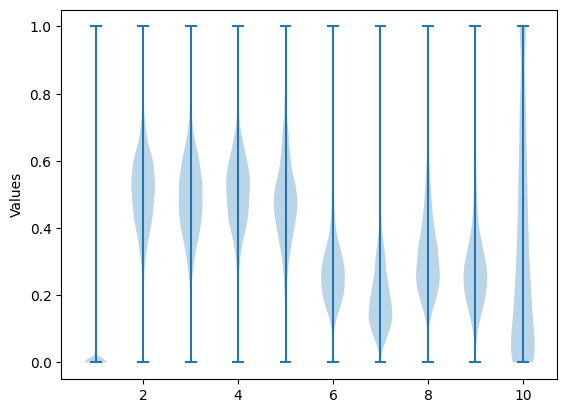

In [48]:
# Scaler ALL numeric data through normalisation 

scaleMinMax = MinMaxScaler(feature_range=(0, 1))  # Scaler ensures values should range between 0 and 1 

X = scaleMinMax.fit_transform(X)

# Create a dataframe of scaled data 
X = pd.DataFrame(X, columns=['population', 'voter_turnout_2008', 'voter_turnout_2012',
                            'voter_turnout_2016', '2022_median_age', '2022_per_capitalincome',
                            'perc_2022_age_25+_no_diploma/highschool',
                            'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income',
                            'lifemode_5'])

# View Scaled data 
print(f'Scaled data features  : \n {X.describe().round(4)}')

# Plot scaled data 
plt.violinplot(X)
plt.ylabel('Values')
plt.show()


# 3. Predict Voter Turnout for the year 2020.

In this model, we will split the data into the training set and the test set. The SVR Model will be trained with the values of the training set and the predictions are tested on the test/validation set. Out of 3108 rows, 70%(2176 rows) are used for training and the model is tested on the remaining 932 rows representing 30% of the observation as given by the condition, test_size=0.3. 

Support Vector Regression (SVR) does not inherently provide feature importances directly as some other models (like tree-based models) do. However, you can use techniques such as permutation feature importance to determine the importance of each feature for an SVR model. Permutation feature importance works by shuffling the values of each feature and measuring the impact on the model's performance.

In [58]:
# Target/dependent variable.
y = data[['voter_turnout_2020']]

# Independent variables were already defined in scaling step above

# Split the data into training(70%) and testing data(30%) ,pick random rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=25)

# create an SVR model with a linear kernel 
svr1 = SVR(kernel='linear') 
  
# train the model on the data 
svr1.fit(X_train, y_train) 

# Compute permutation feature importance
r = permutation_importance(svr1, X_test, y_test, n_repeats=30, random_state=42)
  
# Making predictions on the same data or new data
predictions_train = svr1.predict(X_train)
predictions_test = svr1.predict(X_test)
 
# Evaluating the model
# Mean squared error 
mse_train = mean_squared_error(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
print(f'Mean Squared Error on train data : {mse_train}')
print(f'Mean Squared Error on test data : {mse_test} \n--------------\n\n')
 
# R2 score 
r2_train = r2_score(y_train, predictions_train)
r2_test = r2_score(y_test, predictions_test)
print(f'R-squared for training data : {r2_train}')
print(f'R-squared for test data : {r2_test}')

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error on train data : 0.0016464797650598152
Mean Squared Error on test data : 0.0016495657442334585 
--------------


R-squared for training data : 0.8281919579431469
R-squared for test data : 0.816857335585389


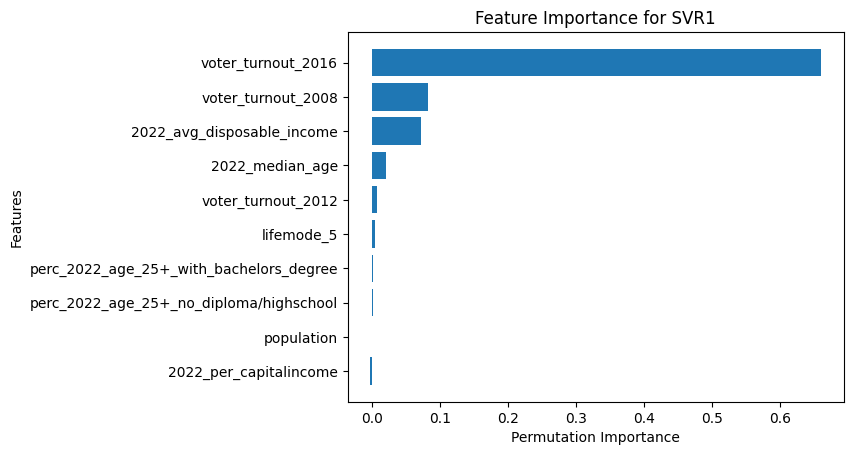

In [61]:
# Plot feature importances
feature_names = X.columns
sorted_idx = r.importances_mean.argsort()

plt.barh(range(len(sorted_idx)), r.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Feature Importance for SVR1")
plt.show()

# 4. Hyperparameter Tunning. 



In [66]:
# Split the data into training(70%) and testing data(30%) ,pick random rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=25)

# Define a pipeline that standardizes the data then applies SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('svr', SVR())
])

# Define the parameter grid
param_grid = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 1],
    'svr__gamma': ['scale', 'auto', 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best negative mean squared error: {best_score}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test score: {test_score}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters: {'svr__C': 1, 'svr__epsilon': 0.01, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Best negative mean squared error: -0.0014523990031315378
Test score: 0.8480850303380078


There was a slight improvement in our model performance symbolised by a 3% increase in R squared value. 